## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage import interpolation
import math
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold

## Load Data

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

## utility function

### graph

In [3]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

### alphabet image

In [4]:
def digit_image(x):
    return np.where(x>=150, x, 0)

### alphabet one-hot encoding

In [5]:
def alpha_one_hot(x):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    
    integer_encoded = label_encoder.fit_transform(x)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    x = onehot_encoder.fit_transform(integer_encoded)
    return x

### Deskew

In [6]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [7]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [8]:
def deskew_all(image_data):
    deskewed = []
    
    for i in range(len(image_data)):
        deskewed.append(deskew(image_data[i].reshape(28,28)))
    
    return np.array(deskewed)[:,:,:,np.newaxis]

## EDA

In [9]:
train

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


In [10]:
test

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,...,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,...,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,...,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,...,2,0,0,4,3,3,3,4,4,2


In [11]:
pd.value_counts(train['letter'])

Z    91
K    90
O    90
H    89
L    89
G    87
M    86
Y    86
U    85
Q    82
T    82
R    81
F    80
X    79
N    77
S    76
D    76
C    74
V    73
A    72
B    71
W    69
J    67
E    66
P    66
I    64
Name: letter, dtype: int64

In [12]:
X_temp = np.array(train[[str(i) for i in range(784)]][:32])
X_temp = X_temp.reshape(-1,1,28,28)
X_temp.shape

(32, 1, 28, 28)

In [13]:
train_digit = train['digit'].values
X_train_letter = train['letter'].values
X_test_letter = test['letter'].values

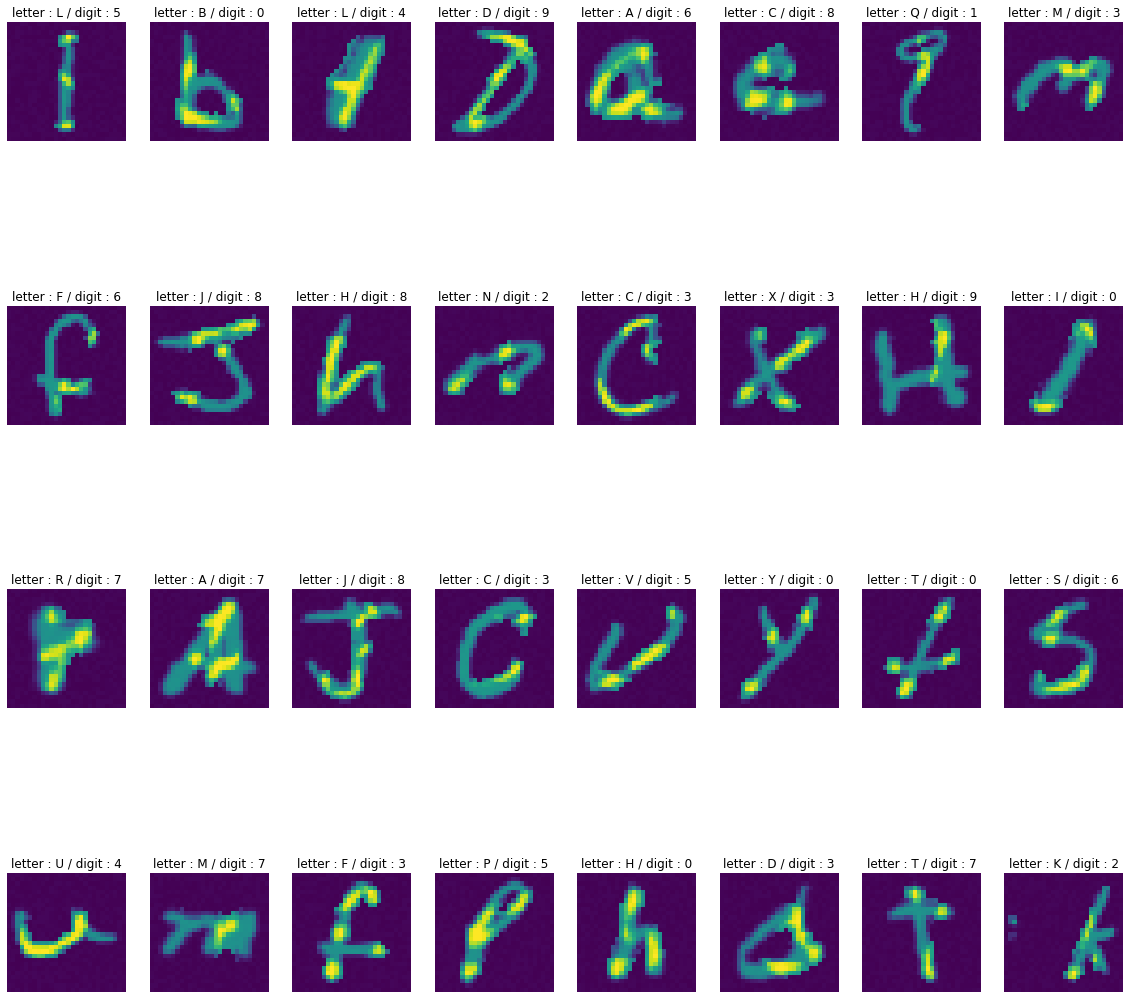

In [14]:
plt.figure(figsize=(20,20))
for idx, (image, digit, letter) in enumerate(zip(X_temp[:32], train_digit[:32] ,X_train_letter[:32])):
    plt.subplot(4,8,idx+1)
    plt.imshow(image[0])
    title = 'letter : {} / digit : {}'.format(letter, digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

## Dataset 

In [15]:
X_train = train.drop(['letter','id','digit'],axis=1)
X_test = test.drop(['letter','id'],axis=1)

In [16]:
X_trains = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

In [17]:
X_trains.shape

(2048, 28, 28, 1)

In [18]:
X_test.shape

(20480, 28, 28, 1)

In [19]:
y_trains = train['digit']

In [20]:
y_trains = utils.to_categorical(y_trains, 10)

In [21]:
y_trains.shape

(2048, 10)

In [22]:
# X_train_letter = alpha_one_hot(X_train_letter)
# X_test_letter = alpha_one_hot(X_test_letter)

In [23]:
X_train_digit = digit_image(X_trains)
X_test_digit = digit_image(X_test)

In [24]:
X_train_alpha = X_trains - X_train_digit/2
X_test_alpha = X_test - X_test_digit/2

X_train_alpha = deskew_all(X_train_alpha)
X_test_alpha = deskew_all(X_test_alpha)

In [25]:
X_trains = np.concatenate((X_trains, X_train_digit, X_train_alpha),axis=-1)
X_test = np.concatenate((X_test, X_test_digit, X_test_alpha),axis=-1)

In [26]:
X_trains.shape

(2048, 28, 28, 3)

In [27]:
X_test.shape

(20480, 28, 28, 3)

## Train

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Input, Flatten, Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [29]:
reduction_ratio=16

In [30]:
def rexnet():    
    input_ = tf.keras.layers.Input(shape=(28,28,3))
    letter = tf.keras.layers.Input(shape=(26))

    conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                                  kernel_constraint=tf.keras.constraints.max_norm(3.))(input_) #28x28x128


    ## Residual Unit1
    batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
    elu1_1 = tf.keras.layers.ELU()(batch1_1)
    res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
    batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
    elu1_2 = tf.keras.layers.ELU()(batch1_2)
    res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
    batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
    elu1_3 = tf.keras.layers.ELU()(batch1_3)
    res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

    # SEBlock1
    ch_input1 = 128
    ch_reduced1 = ch_input1//reduction_ratio
    avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
    sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
    sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
    reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
    mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
    #

    skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
    res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
    ##

    ## Residual Unit2
    batch2_1 = tf.keras.layers.BatchNormalization()(res1)
    elu2_1 = tf.keras.layers.ELU()(batch2_1)
    res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
    batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
    elu2_2 = tf.keras.layers.ELU()(batch2_2)
    res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
    batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
    elu2_3 = tf.keras.layers.ELU()(batch2_3)
    res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


    # SEBlock2
    ch_input2 = 128
    ch_reduced2 = ch_input2//reduction_ratio
    avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
    sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
    sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
    reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
    mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
    #
    skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
    res2 = tf.keras.layers.Add()([mul2, skip2])
    drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
    ##


    ## Residual Unit3
    batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
    elu3_1 = tf.keras.layers.ELU()(batch3_1)
    res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
    batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
    elu3_2 = tf.keras.layers.ELU()(batch3_2)
    res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
    batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
    elu3_3 = tf.keras.layers.ELU()(batch3_3)
    res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


    # SEBlock3
    ch_input3 = 128
    ch_reduced3 = ch_input3//reduction_ratio
    avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
    sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
    sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
    reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
    mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
    #
    skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
    res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
    ##


    ## Residual Unit4
    batch4_1 = tf.keras.layers.BatchNormalization()(res3)
    elu4_1 = tf.keras.layers.ELU()(batch4_1)
    res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
    batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
    elu4_2 = tf.keras.layers.ELU()(batch4_2)
    res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
    batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
    elu4_3 = tf.keras.layers.ELU()(batch4_3)
    res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


    # SEBlock4
    ch_input4 = 256
    ch_reduced4 = ch_input4//reduction_ratio
    avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
    sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
    sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
    reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
    mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
    #
    skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
    res4 = tf.keras.layers.Add()([mul4, skip4])
    pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
    drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
    ##


    ## Residual Unit5
    batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
    elu5_1 = tf.keras.layers.ELU()(batch5_1)
    res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
    batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
    elu5_2 = tf.keras.layers.ELU()(batch5_2)
    res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
    batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
    elu5_3 = tf.keras.layers.ELU()(batch5_3)
    res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


    # SEBlock5
    ch_input5 = 256
    ch_reduced5 = ch_input5//reduction_ratio
    avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
    sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
    sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
    reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
    mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
    #
    skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
    res5 = tf.keras.layers.Add()([mul5, skip5])
    pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
    ##


    ## Residual Unit6
    batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
    elu6_1 = tf.keras.layers.ELU()(batch6_1)
    res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
    batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
    elu6_2 = tf.keras.layers.ELU()(batch6_2)
    res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
    batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
    elu6_3 = tf.keras.layers.ELU()(batch6_3)
    res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
    # SEBlock6
    ch_input6 = 256
    ch_reduced6 = ch_input6//reduction_ratio
    avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
    sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
    sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
    reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
    mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
    #
    skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
    res6 = tf.keras.layers.Add()([mul6, skip6])
    drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
    ##

    ## Residual Unit7
    batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
    elu7_1 = tf.keras.layers.ELU()(batch7_1)
    res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
    batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
    elu7_2 = tf.keras.layers.ELU()(batch7_2)
    res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
    batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
    elu7_3 = tf.keras.layers.ELU()(batch7_3)
    res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
    skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
    res7 = tf.keras.layers.Add()([res7_3, skip7])
    pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) # 2x2x512


    flatten1 = tf.keras.layers.Flatten()(pool7)
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    # gap = tf.keras.layers.GlobalAveragePooling2D()(pool7)
    # dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(gap)

#     drop10 = tf.keras.layers.Dropout(0.2)(dense1)
    drop10 = tf.keras.layers.Dropout(0.5)(dense1)
    output1 = tf.keras.layers.Dense(10 ,activation='softmax', name="digit_output")(drop10)
#     output2 = tf.keras.layers.Dense(26 ,activation='softmax', name="alpha_output")(drop10)
    
#     model = Model(inputs= [input_], outputs=[output1,output2])
    model = Model(inputs= [input_], outputs=[output1])
    
    return model

In [31]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [32]:
valid_datagen = ImageDataGenerator(
    rescale=1./255)

In [33]:
epochs=500
batch_size = 32
n_fold = 10

In [34]:
# k_fold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=2020)

In [35]:
sk_fold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=2020)

model_0
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 53ms/step - loss: 4.8987 - accuracy: 0.0998 - val_loss: 3.5084 - val_accuracy: 0.0833 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 3s 45ms/step - loss: 2.9160 - accuracy: 0.1331 - val_loss: 3.2323 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 41ms/step - loss: 2.7856 - accuracy: 0.1535 - val_loss: 5.1971 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 3s 45ms/step - loss: 2.7527 - accuracy: 0.1623 - val_loss: 2.7951 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 45ms/step - loss: 2.6887 - accuracy: 0.1668 - val_loss: 2.3349 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 2s 39ms/step - loss: 2.5742 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3836 - accuracy: 0.5356 - val_loss: 1.0074 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3513 - accuracy: 0.5500 - val_loss: 1.3718 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3118 - accuracy: 0.5660 - val_loss: 1.3869 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 40ms/step - loss: 1.3047 - accuracy: 0.5583 - val_loss: 1.0358 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3444 - accuracy: 0.5533 - val_loss: 1.2258 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 3s 45ms/step - loss: 1.3047 - accuracy: 0.5594 - val_loss: 0.9095 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 41ms/st

57/57 [==============================] - 2s 41ms/step - loss: 1.0378 - accuracy: 0.6560 - val_loss: 0.6583 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0534 - accuracy: 0.6753 - val_loss: 0.8810 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 40ms/step - loss: 1.0810 - accuracy: 0.6543 - val_loss: 0.6238 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0635 - accuracy: 0.6610 - val_loss: 0.5757 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0878 - accuracy: 0.6405 - val_loss: 0.6384 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9375 - accuracy: 0.6957 - val_loss: 0.7015 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

57/57 [==============================] - 2s 41ms/step - loss: 0.7797 - accuracy: 0.7327 - val_loss: 0.6154 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 157/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6614 - accuracy: 0.7846 - val_loss: 0.6237 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 158/500
57/57 [==============================] - 2s 40ms/step - loss: 0.7135 - accuracy: 0.7775 - val_loss: 0.5235 - val_accuracy: 0.8542 - lr: 7.0000e-04
Epoch 159/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6715 - accuracy: 0.7769 - val_loss: 0.5666 - val_accuracy: 0.8594 - lr: 7.0000e-04
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7266 - accuracy: 0.7681 - val_loss: 0.4937 - val_accuracy: 0.8594 - lr: 7.0000e-04
Epoch 161/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6943 - accuracy: 0.7852 - val_loss: 0.7223 - val_accuracy: 0.8177 - lr: 7.0000e-04
Epoch 162/500
57/57 [===========================

Epoch 207/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4651 - accuracy: 0.8410 - val_loss: 0.5937 - val_accuracy: 0.8594 - lr: 3.4300e-04
Epoch 208/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4684 - accuracy: 0.8437 - val_loss: 0.4800 - val_accuracy: 0.8646 - lr: 3.4300e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4940 - accuracy: 0.8382 - val_loss: 0.4398 - val_accuracy: 0.8750 - lr: 3.4300e-04
Epoch 210/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4891 - accuracy: 0.8432 - val_loss: 0.4973 - val_accuracy: 0.8594 - lr: 3.4300e-04
Epoch 211/500
57/57 [==============================] - 2s 40ms/step - loss: 0.4409 - accuracy: 0.8498 - val_loss: 0.4954 - val_accuracy: 0.8854 - lr: 3.4300e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4551 - accuracy: 0.8498 - val_loss: 0.6560 - val_accuracy: 0.8333 - lr: 3.4300e-04
Epoch 213/500
57/57 [=============

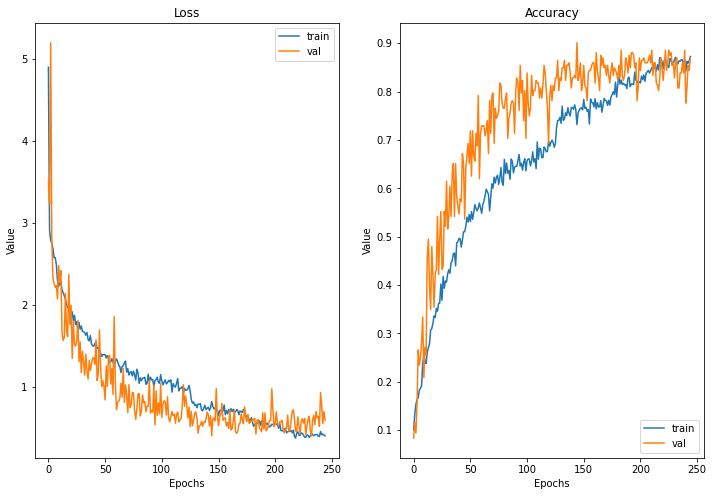

model_1
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 53ms/step - loss: 5.2630 - accuracy: 0.1020 - val_loss: 3.8988 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 3s 44ms/step - loss: 2.8063 - accuracy: 0.1463 - val_loss: 3.3514 - val_accuracy: 0.1302 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 3s 45ms/step - loss: 2.8213 - accuracy: 0.1397 - val_loss: 2.6359 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 41ms/step - loss: 2.6473 - accuracy: 0.1701 - val_loss: 4.7614 - val_accuracy: 0.0885 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 2s 41ms/step - loss: 2.6443 - accuracy: 0.1668 - val_loss: 5.0241 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 2s 40ms/step - loss: 2.4940 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 40ms/step - loss: 1.3498 - accuracy: 0.5367 - val_loss: 1.4526 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3411 - accuracy: 0.5378 - val_loss: 1.3110 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 3s 45ms/step - loss: 1.3727 - accuracy: 0.5395 - val_loss: 0.7862 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3118 - accuracy: 0.5384 - val_loss: 1.8204 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3248 - accuracy: 0.5599 - val_loss: 0.9185 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 40ms/step - loss: 1.2952 - accuracy: 0.5759 - val_loss: 0.7959 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 3s 45ms/st

57/57 [==============================] - 2s 41ms/step - loss: 1.0046 - accuracy: 0.6797 - val_loss: 0.6719 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0407 - accuracy: 0.6681 - val_loss: 0.9332 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 40ms/step - loss: 1.0528 - accuracy: 0.6521 - val_loss: 0.7522 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 40ms/step - loss: 0.9953 - accuracy: 0.6737 - val_loss: 0.6744 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9471 - accuracy: 0.7062 - val_loss: 0.8967 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0490 - accuracy: 0.6632 - val_loss: 0.8341 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

Epoch 157/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6625 - accuracy: 0.7747 - val_loss: 0.8434 - val_accuracy: 0.8073 - lr: 7.0000e-04
Epoch 158/500
57/57 [==============================] - 2s 40ms/step - loss: 0.7268 - accuracy: 0.7631 - val_loss: 0.7079 - val_accuracy: 0.8177 - lr: 7.0000e-04
Epoch 159/500
57/57 [==============================] - 2s 40ms/step - loss: 0.6938 - accuracy: 0.7819 - val_loss: 0.7935 - val_accuracy: 0.8177 - lr: 7.0000e-04
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7593 - accuracy: 0.7653 - val_loss: 0.7171 - val_accuracy: 0.8229 - lr: 7.0000e-04
Epoch 161/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7210 - accuracy: 0.7675 - val_loss: 0.8146 - val_accuracy: 0.8021 - lr: 7.0000e-04
Epoch 162/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6856 - accuracy: 0.7736 - val_loss: 0.7187 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 163/500
57/57 [=============

Epoch 208/500
57/57 [==============================] - 2s 40ms/step - loss: 0.4266 - accuracy: 0.8620 - val_loss: 0.9139 - val_accuracy: 0.8229 - lr: 3.4300e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4593 - accuracy: 0.8448 - val_loss: 0.9218 - val_accuracy: 0.8438 - lr: 3.4300e-04
Epoch 210/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4245 - accuracy: 0.8653 - val_loss: 0.9766 - val_accuracy: 0.8021 - lr: 3.4300e-04
Epoch 211/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4481 - accuracy: 0.8515 - val_loss: 0.8429 - val_accuracy: 0.8438 - lr: 3.4300e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4493 - accuracy: 0.8498 - val_loss: 0.6943 - val_accuracy: 0.8542 - lr: 3.4300e-04
Epoch 213/500
57/57 [==============================] - 2s 40ms/step - loss: 0.4226 - accuracy: 0.8415 - val_loss: 0.7136 - val_accuracy: 0.8698 - lr: 3.4300e-04
Epoch 214/500
57/57 [=============

Epoch 259/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3170 - accuracy: 0.8879 - val_loss: 0.8180 - val_accuracy: 0.8594 - lr: 1.6807e-04
Epoch 260/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3307 - accuracy: 0.8868 - val_loss: 0.8533 - val_accuracy: 0.8438 - lr: 1.6807e-04
Epoch 261/500
57/57 [==============================] - 2s 40ms/step - loss: 0.3356 - accuracy: 0.8912 - val_loss: 0.9703 - val_accuracy: 0.8229 - lr: 1.6807e-04
Epoch 262/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3102 - accuracy: 0.8923 - val_loss: 0.9022 - val_accuracy: 0.8281 - lr: 1.6807e-04
Epoch 263/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3006 - accuracy: 0.9006 - val_loss: 1.0066 - val_accuracy: 0.8281 - lr: 1.6807e-04
Epoch 264/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3015 - accuracy: 0.8962 - val_loss: 0.9515 - val_accuracy: 0.8333 - lr: 1.6807e-04
Epoch 265/500
57/57 [=============

Epoch 310/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2611 - accuracy: 0.9111 - val_loss: 0.8682 - val_accuracy: 0.8385 - lr: 1.1765e-04
Epoch 311/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2806 - accuracy: 0.9028 - val_loss: 0.7278 - val_accuracy: 0.8333 - lr: 1.1765e-04
Epoch 312/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2861 - accuracy: 0.9083 - val_loss: 0.8384 - val_accuracy: 0.8438 - lr: 1.1765e-04
Epoch 313/500
57/57 [==============================] - 2s 40ms/step - loss: 0.2232 - accuracy: 0.9244 - val_loss: 0.8046 - val_accuracy: 0.8490 - lr: 1.1765e-04
Epoch 314/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2502 - accuracy: 0.9094 - val_loss: 0.8285 - val_accuracy: 0.8542 - lr: 1.1765e-04
Epoch 315/500
57/57 [==============================] - 2s 42ms/step - loss: 0.2727 - accuracy: 0.9094 - val_loss: 0.9010 - val_accuracy: 0.8281 - lr: 8.2354e-05


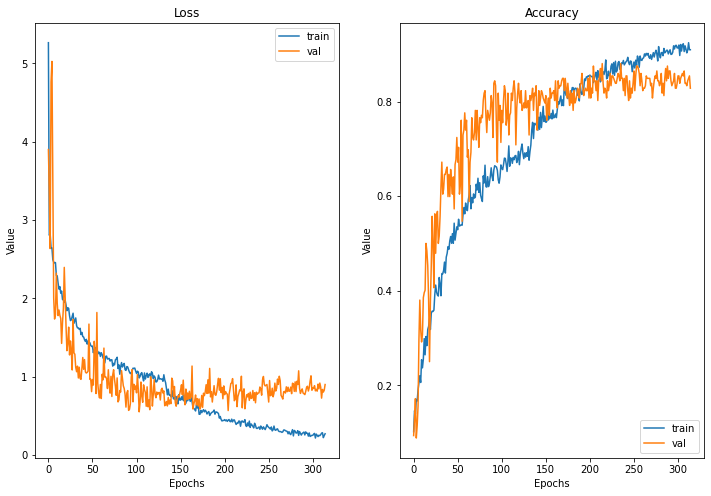

model_2
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 57ms/step - loss: 4.9844 - accuracy: 0.1217 - val_loss: 2.6308 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 3s 44ms/step - loss: 2.8594 - accuracy: 0.1369 - val_loss: 3.2578 - val_accuracy: 0.1042 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 41ms/step - loss: 2.7139 - accuracy: 0.1585 - val_loss: 2.8807 - val_accuracy: 0.1042 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 3s 46ms/step - loss: 2.7951 - accuracy: 0.1568 - val_loss: 3.3830 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 46ms/step - loss: 2.6703 - accuracy: 0.1828 - val_loss: 2.8121 - val_accuracy: 0.1302 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 45ms/step - loss: 2.5791 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 40ms/step - loss: 1.3137 - accuracy: 0.5594 - val_loss: 1.3694 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 3s 46ms/step - loss: 1.3168 - accuracy: 0.5461 - val_loss: 0.7952 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2667 - accuracy: 0.5737 - val_loss: 1.1392 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2803 - accuracy: 0.5610 - val_loss: 2.1958 - val_accuracy: 0.5990 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3154 - accuracy: 0.5676 - val_loss: 0.9965 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3043 - accuracy: 0.5671 - val_loss: 1.0099 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 3s 46ms/st

57/57 [==============================] - 2s 42ms/step - loss: 0.9738 - accuracy: 0.6919 - val_loss: 0.8145 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 3s 46ms/step - loss: 0.9390 - accuracy: 0.6980 - val_loss: 0.7320 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 42ms/step - loss: 0.9285 - accuracy: 0.6969 - val_loss: 1.2313 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 40ms/step - loss: 0.9875 - accuracy: 0.6880 - val_loss: 0.9394 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0052 - accuracy: 0.6847 - val_loss: 0.8915 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9998 - accuracy: 0.6919 - val_loss: 0.9259 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

57/57 [==============================] - 2s 42ms/step - loss: 0.6905 - accuracy: 0.7830 - val_loss: 1.0390 - val_accuracy: 0.7812 - lr: 7.0000e-04
Epoch 158/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6900 - accuracy: 0.7797 - val_loss: 0.9011 - val_accuracy: 0.8333 - lr: 7.0000e-04
Epoch 159/500
57/57 [==============================] - 2s 40ms/step - loss: 0.6836 - accuracy: 0.7742 - val_loss: 1.1270 - val_accuracy: 0.7917 - lr: 7.0000e-04
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6839 - accuracy: 0.7791 - val_loss: 0.6285 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 161/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7118 - accuracy: 0.7758 - val_loss: 0.6439 - val_accuracy: 0.8542 - lr: 7.0000e-04
Epoch 162/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6840 - accuracy: 0.7714 - val_loss: 0.7005 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 163/500
57/57 [===========================

Epoch 208/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5103 - accuracy: 0.8366 - val_loss: 0.9886 - val_accuracy: 0.8073 - lr: 4.9000e-04
Epoch 209/500
57/57 [==============================] - 2s 42ms/step - loss: 0.5099 - accuracy: 0.8327 - val_loss: 0.8090 - val_accuracy: 0.8333 - lr: 4.9000e-04
Epoch 210/500
57/57 [==============================] - 2s 42ms/step - loss: 0.4723 - accuracy: 0.8470 - val_loss: 0.9080 - val_accuracy: 0.8229 - lr: 4.9000e-04
Epoch 211/500
57/57 [==============================] - 2s 43ms/step - loss: 0.4385 - accuracy: 0.8504 - val_loss: 0.6541 - val_accuracy: 0.8438 - lr: 4.9000e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4915 - accuracy: 0.8388 - val_loss: 0.7626 - val_accuracy: 0.8438 - lr: 4.9000e-04
Epoch 213/500
57/57 [==============================] - 3s 44ms/step - loss: 0.5036 - accuracy: 0.8343 - val_loss: 0.9130 - val_accuracy: 0.8438 - lr: 4.9000e-04
Epoch 214/500
57/57 [=============

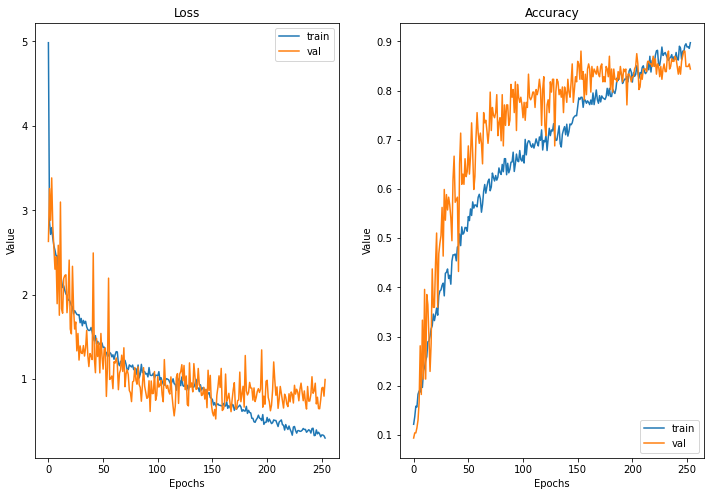

model_3
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 52ms/step - loss: 4.4915 - accuracy: 0.0905 - val_loss: 2.4329 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 41ms/step - loss: 2.8870 - accuracy: 0.1436 - val_loss: 4.1176 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 3s 46ms/step - loss: 2.8160 - accuracy: 0.1541 - val_loss: 4.0139 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 3s 46ms/step - loss: 2.7200 - accuracy: 0.1662 - val_loss: 3.0375 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 45ms/step - loss: 2.6499 - accuracy: 0.1657 - val_loss: 2.6665 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 46ms/step - loss: 2.6073 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 41ms/step - loss: 1.4039 - accuracy: 0.5362 - val_loss: 1.1183 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3354 - accuracy: 0.5522 - val_loss: 1.1172 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.4350 - accuracy: 0.5246 - val_loss: 1.0726 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3357 - accuracy: 0.5428 - val_loss: 0.6850 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3553 - accuracy: 0.5527 - val_loss: 1.0245 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3467 - accuracy: 0.5654 - val_loss: 1.2147 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 40ms/st

57/57 [==============================] - 2s 41ms/step - loss: 1.0628 - accuracy: 0.6582 - val_loss: 0.6169 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0402 - accuracy: 0.6582 - val_loss: 0.9075 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 41ms/step - loss: 1.1026 - accuracy: 0.6593 - val_loss: 0.5790 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 40ms/step - loss: 1.0835 - accuracy: 0.6543 - val_loss: 0.7350 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9995 - accuracy: 0.6825 - val_loss: 0.6225 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0555 - accuracy: 0.6582 - val_loss: 0.8717 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 3s 46ms/step - lo

57/57 [==============================] - 2s 41ms/step - loss: 0.6904 - accuracy: 0.7664 - val_loss: 0.2837 - val_accuracy: 0.8958 - lr: 7.0000e-04
Epoch 158/500
57/57 [==============================] - 2s 40ms/step - loss: 0.7292 - accuracy: 0.7747 - val_loss: 0.3639 - val_accuracy: 0.9010 - lr: 7.0000e-04
Epoch 159/500
57/57 [==============================] - 2s 42ms/step - loss: 0.6876 - accuracy: 0.7841 - val_loss: 0.4074 - val_accuracy: 0.9167 - lr: 7.0000e-04
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6677 - accuracy: 0.7808 - val_loss: 0.3679 - val_accuracy: 0.8906 - lr: 7.0000e-04
Epoch 161/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7857 - accuracy: 0.7449 - val_loss: 0.3970 - val_accuracy: 0.9010 - lr: 7.0000e-04
Epoch 162/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7046 - accuracy: 0.7653 - val_loss: 0.5991 - val_accuracy: 0.8333 - lr: 7.0000e-04
Epoch 163/500
57/57 [===========================

Epoch 208/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5175 - accuracy: 0.8283 - val_loss: 0.6779 - val_accuracy: 0.8385 - lr: 4.9000e-04
Epoch 209/500
57/57 [==============================] - 2s 40ms/step - loss: 0.5412 - accuracy: 0.8227 - val_loss: 0.5160 - val_accuracy: 0.8646 - lr: 4.9000e-04
Epoch 210/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5228 - accuracy: 0.8288 - val_loss: 0.3904 - val_accuracy: 0.8854 - lr: 4.9000e-04
Epoch 211/500
57/57 [==============================] - 2s 42ms/step - loss: 0.5478 - accuracy: 0.8216 - val_loss: 0.4068 - val_accuracy: 0.9010 - lr: 4.9000e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5333 - accuracy: 0.8211 - val_loss: 0.5107 - val_accuracy: 0.8958 - lr: 4.9000e-04
Epoch 213/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5254 - accuracy: 0.8205 - val_loss: 0.4638 - val_accuracy: 0.8958 - lr: 4.9000e-04
Epoch 214/500
57/57 [=============

Epoch 259/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4082 - accuracy: 0.8647 - val_loss: 0.5259 - val_accuracy: 0.8802 - lr: 3.4300e-04
Epoch 260/500
57/57 [==============================] - 2s 42ms/step - loss: 0.3663 - accuracy: 0.8730 - val_loss: 0.4887 - val_accuracy: 0.8854 - lr: 3.4300e-04
Epoch 261/500
57/57 [==============================] - 2s 42ms/step - loss: 0.3852 - accuracy: 0.8609 - val_loss: 0.4485 - val_accuracy: 0.9062 - lr: 3.4300e-04
Epoch 262/500
57/57 [==============================] - 2s 43ms/step - loss: 0.3988 - accuracy: 0.8658 - val_loss: 0.3887 - val_accuracy: 0.9062 - lr: 3.4300e-04
Epoch 263/500
57/57 [==============================] - 2s 44ms/step - loss: 0.3878 - accuracy: 0.8697 - val_loss: 0.5062 - val_accuracy: 0.8802 - lr: 3.4300e-04
Epoch 264/500
57/57 [==============================] - 2s 42ms/step - loss: 0.4249 - accuracy: 0.8570 - val_loss: 0.4651 - val_accuracy: 0.9010 - lr: 3.4300e-04
Epoch 265/500
57/57 [=============

Epoch 310/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2871 - accuracy: 0.9050 - val_loss: 0.4449 - val_accuracy: 0.9115 - lr: 1.6807e-04
Epoch 311/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2572 - accuracy: 0.9111 - val_loss: 0.4539 - val_accuracy: 0.9062 - lr: 1.6807e-04
Epoch 312/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2910 - accuracy: 0.9067 - val_loss: 0.4592 - val_accuracy: 0.8958 - lr: 1.6807e-04
Epoch 313/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2841 - accuracy: 0.9023 - val_loss: 0.4319 - val_accuracy: 0.8958 - lr: 1.6807e-04
Epoch 314/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2816 - accuracy: 0.9017 - val_loss: 0.4246 - val_accuracy: 0.9062 - lr: 1.6807e-04
Epoch 315/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2635 - accuracy: 0.9012 - val_loss: 0.3908 - val_accuracy: 0.9167 - lr: 1.6807e-04
Epoch 316/500
57/57 [=============

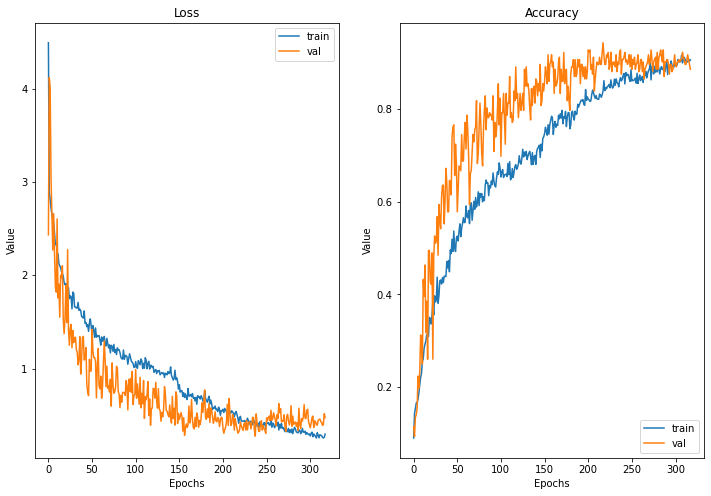

model_4
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 52ms/step - loss: 5.2294 - accuracy: 0.1053 - val_loss: 2.2999 - val_accuracy: 0.1979 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 40ms/step - loss: 2.8392 - accuracy: 0.1430 - val_loss: 2.9516 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 3s 46ms/step - loss: 2.7907 - accuracy: 0.1579 - val_loss: 2.5461 - val_accuracy: 0.2292 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 42ms/step - loss: 2.7569 - accuracy: 0.1535 - val_loss: 2.7154 - val_accuracy: 0.2292 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 45ms/step - loss: 2.6976 - accuracy: 0.1574 - val_loss: 2.1607 - val_accuracy: 0.2396 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 44ms/step - loss: 2.5905 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3549 - accuracy: 0.5445 - val_loss: 1.1631 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 3s 45ms/step - loss: 1.3785 - accuracy: 0.5433 - val_loss: 0.8547 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3067 - accuracy: 0.5754 - val_loss: 1.4343 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 40ms/step - loss: 1.3026 - accuracy: 0.5632 - val_loss: 1.0640 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3725 - accuracy: 0.5483 - val_loss: 0.8661 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3383 - accuracy: 0.5472 - val_loss: 0.9563 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 41ms/st

57/57 [==============================] - 2s 41ms/step - loss: 1.0310 - accuracy: 0.6670 - val_loss: 0.7985 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0011 - accuracy: 0.6698 - val_loss: 0.6711 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9502 - accuracy: 0.6924 - val_loss: 1.2032 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 40ms/step - loss: 1.0312 - accuracy: 0.6654 - val_loss: 0.5690 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9751 - accuracy: 0.6737 - val_loss: 0.8395 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0333 - accuracy: 0.6709 - val_loss: 1.1118 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

57/57 [==============================] - 2s 41ms/step - loss: 0.7080 - accuracy: 0.7786 - val_loss: 0.5839 - val_accuracy: 0.8542 - lr: 7.0000e-04
Epoch 158/500
57/57 [==============================] - 2s 42ms/step - loss: 0.6744 - accuracy: 0.7841 - val_loss: 0.6649 - val_accuracy: 0.8542 - lr: 7.0000e-04
Epoch 159/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6997 - accuracy: 0.7852 - val_loss: 0.6161 - val_accuracy: 0.8333 - lr: 7.0000e-04
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6641 - accuracy: 0.7802 - val_loss: 0.5103 - val_accuracy: 0.8542 - lr: 7.0000e-04
Epoch 161/500
57/57 [==============================] - 2s 40ms/step - loss: 0.7095 - accuracy: 0.7609 - val_loss: 0.5212 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 162/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7257 - accuracy: 0.7708 - val_loss: 0.6508 - val_accuracy: 0.8229 - lr: 7.0000e-04
Epoch 163/500
57/57 [===========================

Epoch 208/500
57/57 [==============================] - 2s 40ms/step - loss: 0.6222 - accuracy: 0.8023 - val_loss: 0.8420 - val_accuracy: 0.8073 - lr: 7.0000e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6150 - accuracy: 0.7896 - val_loss: 0.9159 - val_accuracy: 0.7656 - lr: 7.0000e-04
Epoch 210/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6008 - accuracy: 0.8023 - val_loss: 0.7963 - val_accuracy: 0.7969 - lr: 7.0000e-04
Epoch 211/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6011 - accuracy: 0.8018 - val_loss: 0.5269 - val_accuracy: 0.8594 - lr: 7.0000e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6314 - accuracy: 0.7979 - val_loss: 0.6303 - val_accuracy: 0.8333 - lr: 7.0000e-04
Epoch 213/500
57/57 [==============================] - 2s 40ms/step - loss: 0.6284 - accuracy: 0.8007 - val_loss: 0.5962 - val_accuracy: 0.8385 - lr: 7.0000e-04
Epoch 214/500
57/57 [=============

Epoch 259/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4692 - accuracy: 0.8526 - val_loss: 0.6007 - val_accuracy: 0.8385 - lr: 4.9000e-04
Epoch 260/500
57/57 [==============================] - 3s 50ms/step - loss: 0.4284 - accuracy: 0.8647 - val_loss: 0.5999 - val_accuracy: 0.8906 - lr: 4.9000e-04
Epoch 261/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4315 - accuracy: 0.8575 - val_loss: 0.6732 - val_accuracy: 0.8542 - lr: 4.9000e-04
Epoch 262/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4625 - accuracy: 0.8542 - val_loss: 0.5384 - val_accuracy: 0.8750 - lr: 4.9000e-04
Epoch 263/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4424 - accuracy: 0.8526 - val_loss: 0.4848 - val_accuracy: 0.8646 - lr: 4.9000e-04
Epoch 264/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4633 - accuracy: 0.8531 - val_loss: 0.6725 - val_accuracy: 0.8490 - lr: 4.9000e-04
Epoch 265/500
57/57 [=============

Epoch 310/500
57/57 [==============================] - 2s 40ms/step - loss: 0.2705 - accuracy: 0.9144 - val_loss: 0.6025 - val_accuracy: 0.8646 - lr: 2.4010e-04
Epoch 311/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3058 - accuracy: 0.8967 - val_loss: 0.7068 - val_accuracy: 0.8490 - lr: 2.4010e-04
Epoch 312/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3007 - accuracy: 0.8990 - val_loss: 0.7389 - val_accuracy: 0.8490 - lr: 2.4010e-04
Epoch 313/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2896 - accuracy: 0.8918 - val_loss: 0.6334 - val_accuracy: 0.8698 - lr: 2.4010e-04
Epoch 314/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2821 - accuracy: 0.8978 - val_loss: 0.6003 - val_accuracy: 0.8646 - lr: 2.4010e-04
Epoch 315/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3010 - accuracy: 0.8973 - val_loss: 0.7929 - val_accuracy: 0.8594 - lr: 2.4010e-04
Epoch 316/500
57/57 [=============

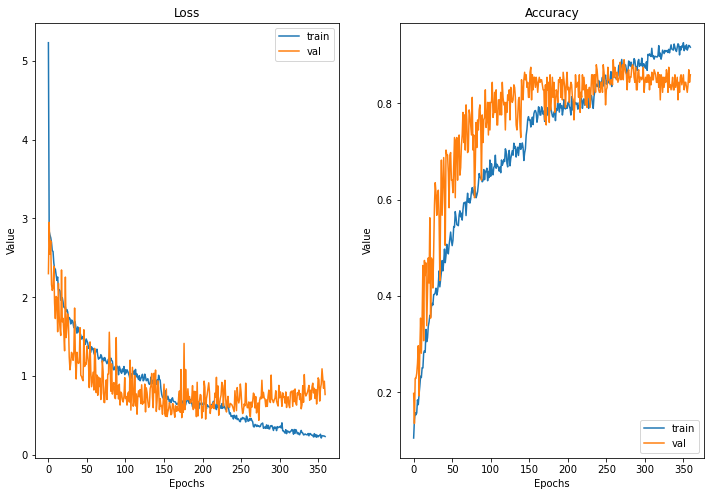

model_5
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 51ms/step - loss: 4.9213 - accuracy: 0.1338 - val_loss: 3.7886 - val_accuracy: 0.1042 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 42ms/step - loss: 2.9025 - accuracy: 0.1541 - val_loss: 4.5388 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 3s 45ms/step - loss: 2.8166 - accuracy: 0.1480 - val_loss: 3.9238 - val_accuracy: 0.1198 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 3s 45ms/step - loss: 2.7284 - accuracy: 0.1651 - val_loss: 4.1172 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 46ms/step - loss: 2.7079 - accuracy: 0.1612 - val_loss: 3.1175 - val_accuracy: 0.1510 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 46ms/step - loss: 2.5954 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 3s 45ms/step - loss: 1.3051 - accuracy: 0.5699 - val_loss: 0.9415 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3447 - accuracy: 0.5544 - val_loss: 1.2810 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 42ms/step - loss: 1.2783 - accuracy: 0.5660 - val_loss: 0.9372 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 40ms/step - loss: 1.2826 - accuracy: 0.5737 - val_loss: 0.9829 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 40ms/step - loss: 1.3252 - accuracy: 0.5715 - val_loss: 1.6586 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2954 - accuracy: 0.5787 - val_loss: 1.0055 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 41ms/st

57/57 [==============================] - 2s 41ms/step - loss: 1.0444 - accuracy: 0.6781 - val_loss: 0.5488 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0152 - accuracy: 0.6731 - val_loss: 0.7984 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 42ms/step - loss: 1.0353 - accuracy: 0.6621 - val_loss: 0.5379 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0462 - accuracy: 0.6665 - val_loss: 0.9129 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0211 - accuracy: 0.6742 - val_loss: 0.6755 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 40ms/step - loss: 1.0675 - accuracy: 0.6593 - val_loss: 0.6547 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

Epoch 157/500
57/57 [==============================] - 2s 42ms/step - loss: 0.7074 - accuracy: 0.7609 - val_loss: 0.5041 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 158/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6913 - accuracy: 0.7769 - val_loss: 0.7972 - val_accuracy: 0.8177 - lr: 7.0000e-04
Epoch 159/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6787 - accuracy: 0.7797 - val_loss: 0.5368 - val_accuracy: 0.8542 - lr: 7.0000e-04
Epoch 160/500
57/57 [==============================] - 3s 45ms/step - loss: 0.7303 - accuracy: 0.7642 - val_loss: 0.5301 - val_accuracy: 0.8958 - lr: 7.0000e-04
Epoch 161/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6922 - accuracy: 0.7714 - val_loss: 0.7209 - val_accuracy: 0.8385 - lr: 7.0000e-04
Epoch 162/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6670 - accuracy: 0.7819 - val_loss: 0.5417 - val_accuracy: 0.8490 - lr: 7.0000e-04
Epoch 163/500
57/57 [=============

Epoch 208/500
57/57 [==============================] - 2s 40ms/step - loss: 0.5122 - accuracy: 0.8233 - val_loss: 0.6086 - val_accuracy: 0.8698 - lr: 4.9000e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4730 - accuracy: 0.8410 - val_loss: 0.6723 - val_accuracy: 0.8177 - lr: 4.9000e-04
Epoch 210/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5163 - accuracy: 0.8316 - val_loss: 0.4157 - val_accuracy: 0.8906 - lr: 4.9000e-04
Epoch 211/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5297 - accuracy: 0.8255 - val_loss: 0.4762 - val_accuracy: 0.8542 - lr: 3.4300e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4373 - accuracy: 0.8570 - val_loss: 0.5540 - val_accuracy: 0.8594 - lr: 3.4300e-04
Epoch 213/500
57/57 [==============================] - 2s 42ms/step - loss: 0.4683 - accuracy: 0.8443 - val_loss: 0.5355 - val_accuracy: 0.8854 - lr: 3.4300e-04
Epoch 214/500
57/57 [=============

Epoch 259/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3097 - accuracy: 0.9056 - val_loss: 0.5220 - val_accuracy: 0.8646 - lr: 2.4010e-04
Epoch 260/500
57/57 [==============================] - 2s 40ms/step - loss: 0.3683 - accuracy: 0.8763 - val_loss: 0.5500 - val_accuracy: 0.8594 - lr: 2.4010e-04
Epoch 261/500
57/57 [==============================] - 2s 42ms/step - loss: 0.3189 - accuracy: 0.8890 - val_loss: 0.5171 - val_accuracy: 0.8646 - lr: 2.4010e-04
Epoch 262/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2545 - accuracy: 0.9161 - val_loss: 0.5417 - val_accuracy: 0.8594 - lr: 2.4010e-04
Epoch 263/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3272 - accuracy: 0.8978 - val_loss: 0.5053 - val_accuracy: 0.8854 - lr: 2.4010e-04
Epoch 264/500
57/57 [==============================] - 2s 42ms/step - loss: 0.3531 - accuracy: 0.8730 - val_loss: 0.4548 - val_accuracy: 0.8646 - lr: 2.4010e-04
Epoch 265/500
57/57 [=============

Epoch 310/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2620 - accuracy: 0.9177 - val_loss: 0.5255 - val_accuracy: 0.8542 - lr: 1.1765e-04
Epoch 311/500
57/57 [==============================] - 2s 40ms/step - loss: 0.2794 - accuracy: 0.9017 - val_loss: 0.5582 - val_accuracy: 0.8698 - lr: 1.1765e-04
Epoch 312/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2744 - accuracy: 0.9017 - val_loss: 0.4888 - val_accuracy: 0.8802 - lr: 1.1765e-04
Epoch 313/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2648 - accuracy: 0.9128 - val_loss: 0.5426 - val_accuracy: 0.8750 - lr: 1.1765e-04
Epoch 314/500
57/57 [==============================] - 2s 42ms/step - loss: 0.3042 - accuracy: 0.9050 - val_loss: 0.5767 - val_accuracy: 0.8594 - lr: 1.1765e-04
Epoch 315/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2430 - accuracy: 0.9238 - val_loss: 0.5915 - val_accuracy: 0.8854 - lr: 1.1765e-04
Epoch 316/500
57/57 [=============

Epoch 361/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2046 - accuracy: 0.9304 - val_loss: 0.5648 - val_accuracy: 0.8698 - lr: 8.2354e-05
Epoch 362/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2457 - accuracy: 0.9122 - val_loss: 0.5895 - val_accuracy: 0.8594 - lr: 8.2354e-05
Epoch 363/500
57/57 [==============================] - 2s 40ms/step - loss: 0.2238 - accuracy: 0.9221 - val_loss: 0.6351 - val_accuracy: 0.8646 - lr: 8.2354e-05
Epoch 364/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2226 - accuracy: 0.9271 - val_loss: 0.6208 - val_accuracy: 0.8698 - lr: 8.2354e-05
Epoch 365/500
57/57 [==============================] - 2s 42ms/step - loss: 0.2281 - accuracy: 0.9282 - val_loss: 0.6213 - val_accuracy: 0.8594 - lr: 8.2354e-05
Epoch 366/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2078 - accuracy: 0.9260 - val_loss: 0.6352 - val_accuracy: 0.8646 - lr: 5.7648e-05
Epoch 367/500
57/57 [=============

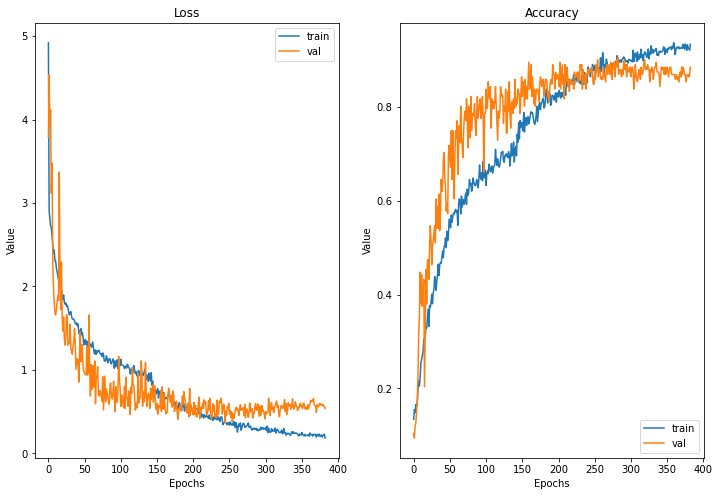

model_6
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 51ms/step - loss: 5.3430 - accuracy: 0.1146 - val_loss: 2.6700 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 42ms/step - loss: 2.8845 - accuracy: 0.1220 - val_loss: 3.3714 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 41ms/step - loss: 2.7933 - accuracy: 0.1397 - val_loss: 3.2450 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 3s 45ms/step - loss: 2.7463 - accuracy: 0.1474 - val_loss: 3.2777 - val_accuracy: 0.1510 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 44ms/step - loss: 2.6102 - accuracy: 0.1739 - val_loss: 2.9471 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 45ms/step - loss: 2.6079 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 3s 46ms/step - loss: 1.3290 - accuracy: 0.5433 - val_loss: 0.9844 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 3s 45ms/step - loss: 1.2656 - accuracy: 0.5859 - val_loss: 0.7595 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2962 - accuracy: 0.5649 - val_loss: 0.9512 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3719 - accuracy: 0.5273 - val_loss: 1.4582 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3119 - accuracy: 0.5737 - val_loss: 0.8378 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2525 - accuracy: 0.5826 - val_loss: 0.9619 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 41ms/st

57/57 [==============================] - 2s 41ms/step - loss: 0.7718 - accuracy: 0.7305 - val_loss: 0.8416 - val_accuracy: 0.7865 - lr: 7.0000e-04
Epoch 106/500
57/57 [==============================] - 2s 42ms/step - loss: 0.8178 - accuracy: 0.7300 - val_loss: 0.5597 - val_accuracy: 0.8333 - lr: 7.0000e-04
Epoch 107/500
57/57 [==============================] - 3s 45ms/step - loss: 0.8041 - accuracy: 0.7322 - val_loss: 0.6805 - val_accuracy: 0.8385 - lr: 7.0000e-04
Epoch 108/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7743 - accuracy: 0.7488 - val_loss: 0.8988 - val_accuracy: 0.7448 - lr: 7.0000e-04
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7991 - accuracy: 0.7399 - val_loss: 1.3372 - val_accuracy: 0.6979 - lr: 7.0000e-04
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7735 - accuracy: 0.7449 - val_loss: 0.8296 - val_accuracy: 0.7865 - lr: 7.0000e-04
Epoch 111/500
57/57 [===========================

Epoch 156/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5517 - accuracy: 0.8266 - val_loss: 0.7056 - val_accuracy: 0.8177 - lr: 4.9000e-04
Epoch 157/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5624 - accuracy: 0.8134 - val_loss: 0.8791 - val_accuracy: 0.7969 - lr: 4.9000e-04
Epoch 158/500
57/57 [==============================] - 2s 42ms/step - loss: 0.5915 - accuracy: 0.8134 - val_loss: 0.9678 - val_accuracy: 0.7812 - lr: 4.9000e-04
Epoch 159/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5432 - accuracy: 0.8222 - val_loss: 1.0625 - val_accuracy: 0.7969 - lr: 4.9000e-04
Epoch 160/500
57/57 [==============================] - 2s 40ms/step - loss: 0.5190 - accuracy: 0.8266 - val_loss: 1.0648 - val_accuracy: 0.7969 - lr: 4.9000e-04
Epoch 161/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5535 - accuracy: 0.8167 - val_loss: 0.8185 - val_accuracy: 0.7865 - lr: 4.9000e-04
Epoch 162/500
57/57 [=============

Epoch 207/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3372 - accuracy: 0.8774 - val_loss: 1.0962 - val_accuracy: 0.7969 - lr: 2.4010e-04
Epoch 208/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3575 - accuracy: 0.8691 - val_loss: 0.9879 - val_accuracy: 0.8177 - lr: 2.4010e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3303 - accuracy: 0.8863 - val_loss: 1.0015 - val_accuracy: 0.8125 - lr: 2.4010e-04
Epoch 210/500
57/57 [==============================] - 2s 40ms/step - loss: 0.3567 - accuracy: 0.8680 - val_loss: 0.9439 - val_accuracy: 0.8177 - lr: 2.4010e-04
Epoch 211/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2961 - accuracy: 0.9028 - val_loss: 1.0532 - val_accuracy: 0.8021 - lr: 2.4010e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3791 - accuracy: 0.8741 - val_loss: 0.9118 - val_accuracy: 0.8177 - lr: 2.4010e-04
Epoch 213/500
57/57 [=============

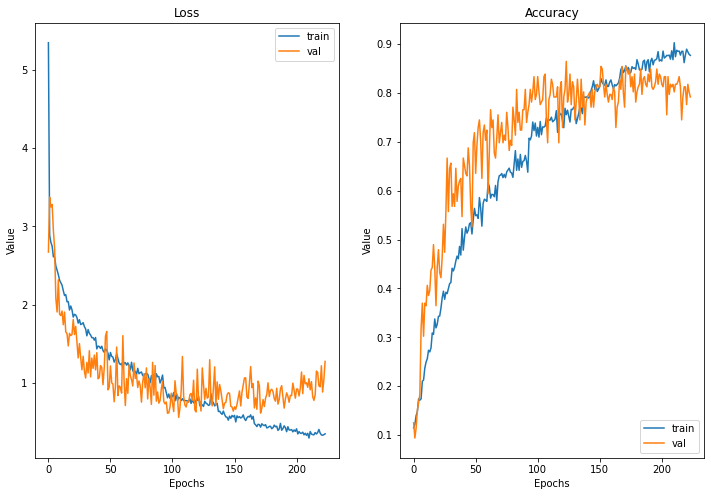

model_7
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 51ms/step - loss: 4.8065 - accuracy: 0.0932 - val_loss: 2.4064 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 41ms/step - loss: 2.9335 - accuracy: 0.1242 - val_loss: 2.9238 - val_accuracy: 0.1094 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 42ms/step - loss: 2.8782 - accuracy: 0.1298 - val_loss: 3.5177 - val_accuracy: 0.0990 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 42ms/step - loss: 2.7505 - accuracy: 0.1496 - val_loss: 3.4049 - val_accuracy: 0.1094 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 44ms/step - loss: 2.6499 - accuracy: 0.1750 - val_loss: 3.5369 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 46ms/step - loss: 2.5612 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 40ms/step - loss: 1.3684 - accuracy: 0.5456 - val_loss: 1.0431 - val_accuracy: 0.6510 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3892 - accuracy: 0.5467 - val_loss: 0.9695 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3426 - accuracy: 0.5494 - val_loss: 0.8744 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.4069 - accuracy: 0.5268 - val_loss: 1.0962 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3993 - accuracy: 0.5312 - val_loss: 1.1610 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3983 - accuracy: 0.5362 - val_loss: 0.8710 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 41ms/st

57/57 [==============================] - 2s 41ms/step - loss: 1.0464 - accuracy: 0.6748 - val_loss: 1.0120 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0286 - accuracy: 0.6576 - val_loss: 0.8379 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0572 - accuracy: 0.6659 - val_loss: 0.6783 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0580 - accuracy: 0.6637 - val_loss: 1.1159 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0063 - accuracy: 0.6830 - val_loss: 0.7210 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0463 - accuracy: 0.6643 - val_loss: 0.6523 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

57/57 [==============================] - 2s 41ms/step - loss: 0.7275 - accuracy: 0.7659 - val_loss: 0.6962 - val_accuracy: 0.8125 - lr: 7.0000e-04
Epoch 158/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7204 - accuracy: 0.7626 - val_loss: 1.1067 - val_accuracy: 0.7812 - lr: 7.0000e-04
Epoch 159/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7650 - accuracy: 0.7488 - val_loss: 0.6531 - val_accuracy: 0.8385 - lr: 7.0000e-04
Epoch 160/500
57/57 [==============================] - 2s 40ms/step - loss: 0.6989 - accuracy: 0.7697 - val_loss: 0.5921 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 161/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6910 - accuracy: 0.7769 - val_loss: 0.4845 - val_accuracy: 0.8542 - lr: 7.0000e-04
Epoch 162/500
57/57 [==============================] - 2s 41ms/step - loss: 0.7516 - accuracy: 0.7631 - val_loss: 0.5885 - val_accuracy: 0.8490 - lr: 7.0000e-04
Epoch 163/500
57/57 [===========================

Epoch 208/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6508 - accuracy: 0.7791 - val_loss: 0.8835 - val_accuracy: 0.8177 - lr: 7.0000e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6594 - accuracy: 0.7863 - val_loss: 0.5836 - val_accuracy: 0.8698 - lr: 7.0000e-04
Epoch 210/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6243 - accuracy: 0.7951 - val_loss: 0.5538 - val_accuracy: 0.8906 - lr: 7.0000e-04
Epoch 211/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6036 - accuracy: 0.8100 - val_loss: 0.6215 - val_accuracy: 0.8698 - lr: 7.0000e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6911 - accuracy: 0.7791 - val_loss: 0.7600 - val_accuracy: 0.8542 - lr: 7.0000e-04
Epoch 213/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6282 - accuracy: 0.7968 - val_loss: 0.6061 - val_accuracy: 0.8750 - lr: 7.0000e-04
Epoch 214/500
57/57 [=============

Epoch 259/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4998 - accuracy: 0.8366 - val_loss: 0.4390 - val_accuracy: 0.8802 - lr: 4.9000e-04
Epoch 260/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4580 - accuracy: 0.8410 - val_loss: 0.6240 - val_accuracy: 0.8542 - lr: 4.9000e-04
Epoch 261/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4619 - accuracy: 0.8454 - val_loss: 0.6513 - val_accuracy: 0.8438 - lr: 4.9000e-04
Epoch 262/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4699 - accuracy: 0.8415 - val_loss: 0.5954 - val_accuracy: 0.8750 - lr: 4.9000e-04
Epoch 263/500
57/57 [==============================] - 2s 40ms/step - loss: 0.4579 - accuracy: 0.8470 - val_loss: 0.5856 - val_accuracy: 0.8750 - lr: 4.9000e-04
Epoch 264/500
57/57 [==============================] - 3s 45ms/step - loss: 0.4555 - accuracy: 0.8504 - val_loss: 0.5582 - val_accuracy: 0.9062 - lr: 4.9000e-04
Epoch 265/500
57/57 [=============

Epoch 310/500
57/57 [==============================] - 2s 40ms/step - loss: 0.2767 - accuracy: 0.9122 - val_loss: 0.6443 - val_accuracy: 0.8490 - lr: 2.4010e-04
Epoch 311/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3120 - accuracy: 0.8990 - val_loss: 0.7535 - val_accuracy: 0.8333 - lr: 2.4010e-04
Epoch 312/500
57/57 [==============================] - 2s 42ms/step - loss: 0.3074 - accuracy: 0.9006 - val_loss: 0.6652 - val_accuracy: 0.8802 - lr: 2.4010e-04
Epoch 313/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3213 - accuracy: 0.8956 - val_loss: 0.6807 - val_accuracy: 0.8646 - lr: 2.4010e-04
Epoch 314/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3219 - accuracy: 0.8912 - val_loss: 0.8498 - val_accuracy: 0.8646 - lr: 2.4010e-04
Epoch 315/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3075 - accuracy: 0.8978 - val_loss: 0.6280 - val_accuracy: 0.8646 - lr: 2.4010e-04
Epoch 316/500
57/57 [=============

Epoch 361/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2372 - accuracy: 0.9133 - val_loss: 0.7264 - val_accuracy: 0.8594 - lr: 1.6807e-04
Epoch 362/500
57/57 [==============================] - 2s 42ms/step - loss: 0.2456 - accuracy: 0.9172 - val_loss: 0.5976 - val_accuracy: 0.8750 - lr: 1.6807e-04
Epoch 363/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2404 - accuracy: 0.9199 - val_loss: 0.6348 - val_accuracy: 0.8698 - lr: 1.6807e-04
Epoch 364/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2432 - accuracy: 0.9117 - val_loss: 0.6713 - val_accuracy: 0.8802 - lr: 1.6807e-04
Epoch 365/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2263 - accuracy: 0.9266 - val_loss: 0.6413 - val_accuracy: 0.8854 - lr: 1.6807e-04
Epoch 366/500
57/57 [==============================] - 2s 40ms/step - loss: 0.2238 - accuracy: 0.9244 - val_loss: 0.5570 - val_accuracy: 0.9010 - lr: 1.6807e-04
Epoch 367/500
57/57 [=============

Epoch 412/500
57/57 [==============================] - 2s 41ms/step - loss: 0.1800 - accuracy: 0.9376 - val_loss: 0.7627 - val_accuracy: 0.8802 - lr: 8.2354e-05
Epoch 413/500
57/57 [==============================] - 2s 40ms/step - loss: 0.1996 - accuracy: 0.9332 - val_loss: 0.6206 - val_accuracy: 0.8958 - lr: 8.2354e-05
Epoch 414/500
57/57 [==============================] - 2s 41ms/step - loss: 0.1937 - accuracy: 0.9387 - val_loss: 0.5564 - val_accuracy: 0.8906 - lr: 8.2354e-05
Epoch 415/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2157 - accuracy: 0.9288 - val_loss: 0.5371 - val_accuracy: 0.8906 - lr: 8.2354e-05
Epoch 416/500
57/57 [==============================] - 2s 41ms/step - loss: 0.1766 - accuracy: 0.9332 - val_loss: 0.5827 - val_accuracy: 0.8854 - lr: 8.2354e-05
Epoch 417/500
57/57 [==============================] - 2s 41ms/step - loss: 0.1984 - accuracy: 0.9277 - val_loss: 0.5512 - val_accuracy: 0.9010 - lr: 8.2354e-05
Epoch 418/500
57/57 [=============

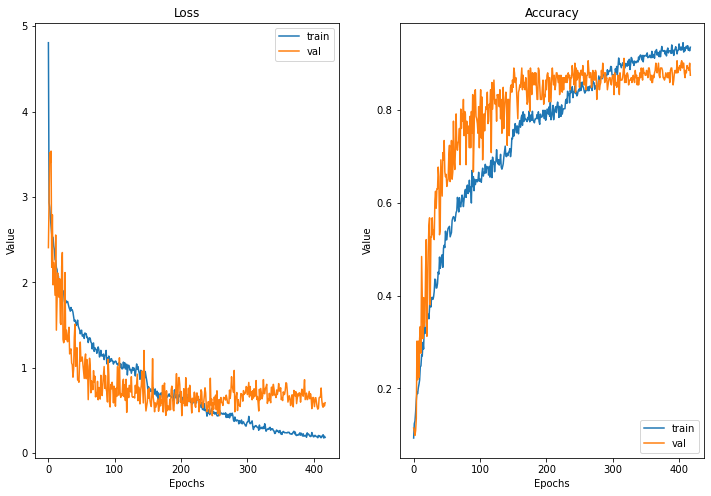

model_8
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 51ms/step - loss: 4.7643 - accuracy: 0.1266 - val_loss: 4.0994 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 3s 46ms/step - loss: 2.8972 - accuracy: 0.1325 - val_loss: 3.8036 - val_accuracy: 0.1042 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 3s 45ms/step - loss: 2.8799 - accuracy: 0.1435 - val_loss: 3.5801 - val_accuracy: 0.1094 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 44ms/step - loss: 2.7413 - accuracy: 0.1700 - val_loss: 2.6726 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 45ms/step - loss: 2.6802 - accuracy: 0.1611 - val_loss: 2.4475 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 45ms/step - loss: 2.6097 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 3s 45ms/step - loss: 1.3387 - accuracy: 0.5513 - val_loss: 0.8883 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3714 - accuracy: 0.5381 - val_loss: 1.1118 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3265 - accuracy: 0.5646 - val_loss: 0.9738 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3363 - accuracy: 0.5596 - val_loss: 1.1416 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3230 - accuracy: 0.5469 - val_loss: 1.3341 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3490 - accuracy: 0.5486 - val_loss: 1.3344 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 42ms/st

57/57 [==============================] - 2s 41ms/step - loss: 1.0612 - accuracy: 0.6634 - val_loss: 0.7331 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0473 - accuracy: 0.6667 - val_loss: 0.7516 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 42ms/step - loss: 1.0537 - accuracy: 0.6783 - val_loss: 0.7231 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 3s 46ms/step - loss: 0.9459 - accuracy: 0.6932 - val_loss: 0.4812 - val_accuracy: 0.8854 - lr: 7.0000e-04
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8516 - accuracy: 0.7141 - val_loss: 0.6668 - val_accuracy: 0.8125 - lr: 7.0000e-04
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8505 - accuracy: 0.7185 - val_loss: 0.5520 - val_accuracy: 0.8385 - lr: 7.0000e-04
Epoch 111/500
57/57 [==============================] - 2s 41

57/57 [==============================] - 2s 42ms/step - loss: 0.5758 - accuracy: 0.7964 - val_loss: 0.8689 - val_accuracy: 0.8021 - lr: 4.9000e-04
Epoch 157/500
57/57 [==============================] - 2s 42ms/step - loss: 0.6184 - accuracy: 0.7980 - val_loss: 0.5091 - val_accuracy: 0.8385 - lr: 4.9000e-04
Epoch 158/500
57/57 [==============================] - 2s 40ms/step - loss: 0.5666 - accuracy: 0.8052 - val_loss: 0.6030 - val_accuracy: 0.8542 - lr: 4.9000e-04
Epoch 159/500
57/57 [==============================] - 2s 42ms/step - loss: 0.5821 - accuracy: 0.8041 - val_loss: 0.5368 - val_accuracy: 0.8594 - lr: 4.9000e-04
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5662 - accuracy: 0.8206 - val_loss: 0.4735 - val_accuracy: 0.8594 - lr: 4.9000e-04
Epoch 161/500
57/57 [==============================] - 2s 42ms/step - loss: 0.5437 - accuracy: 0.8146 - val_loss: 0.7775 - val_accuracy: 0.8281 - lr: 4.9000e-04
Epoch 162/500
57/57 [===========================

Epoch 207/500
57/57 [==============================] - 2s 42ms/step - loss: 0.4690 - accuracy: 0.8416 - val_loss: 0.5948 - val_accuracy: 0.8594 - lr: 3.4300e-04
Epoch 208/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4535 - accuracy: 0.8488 - val_loss: 0.7628 - val_accuracy: 0.8438 - lr: 3.4300e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4017 - accuracy: 0.8620 - val_loss: 0.6387 - val_accuracy: 0.8646 - lr: 3.4300e-04
Epoch 210/500
57/57 [==============================] - 2s 40ms/step - loss: 0.4521 - accuracy: 0.8482 - val_loss: 0.6361 - val_accuracy: 0.8542 - lr: 3.4300e-04
Epoch 211/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4118 - accuracy: 0.8593 - val_loss: 0.5902 - val_accuracy: 0.8802 - lr: 3.4300e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4554 - accuracy: 0.8394 - val_loss: 0.6432 - val_accuracy: 0.8698 - lr: 3.4300e-04
Epoch 213/500
57/57 [=============

Epoch 258/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2967 - accuracy: 0.9045 - val_loss: 0.5414 - val_accuracy: 0.8594 - lr: 1.6807e-04
Epoch 259/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2815 - accuracy: 0.9034 - val_loss: 0.6393 - val_accuracy: 0.8750 - lr: 1.6807e-04
Epoch 260/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3156 - accuracy: 0.8891 - val_loss: 0.7128 - val_accuracy: 0.8385 - lr: 1.6807e-04
Epoch 261/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2957 - accuracy: 0.9012 - val_loss: 0.6218 - val_accuracy: 0.8698 - lr: 1.6807e-04
Epoch 262/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2823 - accuracy: 0.9078 - val_loss: 0.6838 - val_accuracy: 0.8542 - lr: 1.6807e-04
Epoch 263/500
57/57 [==============================] - 2s 40ms/step - loss: 0.2936 - accuracy: 0.9012 - val_loss: 0.6438 - val_accuracy: 0.8854 - lr: 1.6807e-04
Epoch 264/500
57/57 [=============

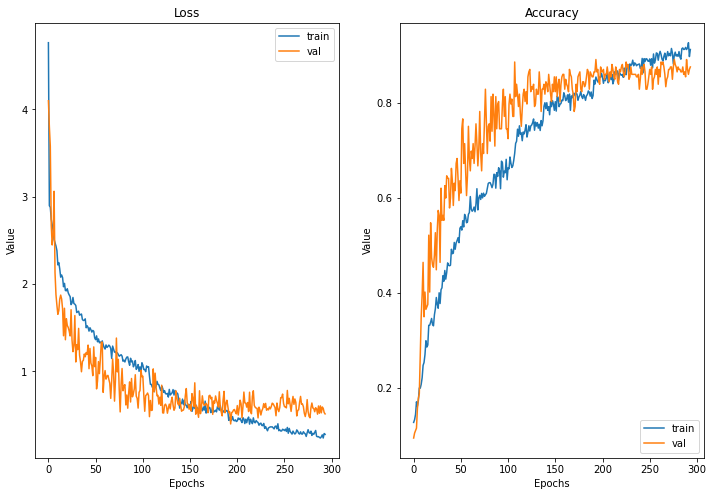

model_9
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 51ms/step - loss: 5.1099 - accuracy: 0.1151 - val_loss: 2.3156 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 42ms/step - loss: 2.8444 - accuracy: 0.1435 - val_loss: 2.4843 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 41ms/step - loss: 2.8080 - accuracy: 0.1490 - val_loss: 3.2149 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 41ms/step - loss: 2.6492 - accuracy: 0.1639 - val_loss: 3.1912 - val_accuracy: 0.1042 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 2s 40ms/step - loss: 2.6456 - accuracy: 0.1694 - val_loss: 2.6288 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 46ms/step - loss: 2.5452 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3405 - accuracy: 0.5535 - val_loss: 0.8686 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 40ms/step - loss: 1.3540 - accuracy: 0.5513 - val_loss: 0.9824 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3396 - accuracy: 0.5497 - val_loss: 1.0082 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 42ms/step - loss: 1.2464 - accuracy: 0.5745 - val_loss: 1.0658 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2762 - accuracy: 0.5684 - val_loss: 1.2118 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3218 - accuracy: 0.5568 - val_loss: 1.0558 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 40ms/st

57/57 [==============================] - 2s 41ms/step - loss: 0.9529 - accuracy: 0.6992 - val_loss: 0.7633 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9561 - accuracy: 0.6904 - val_loss: 0.7447 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9719 - accuracy: 0.6727 - val_loss: 0.8112 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0118 - accuracy: 0.6617 - val_loss: 0.7548 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 40ms/step - loss: 0.9923 - accuracy: 0.6661 - val_loss: 0.7264 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 42ms/step - loss: 1.0317 - accuracy: 0.6634 - val_loss: 1.1868 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 3s 46ms/step - lo

57/57 [==============================] - 2s 41ms/step - loss: 0.8559 - accuracy: 0.7390 - val_loss: 0.4634 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 158/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8610 - accuracy: 0.7357 - val_loss: 0.7941 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 159/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8891 - accuracy: 0.7219 - val_loss: 0.5610 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8681 - accuracy: 0.7318 - val_loss: 0.4709 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 161/500
57/57 [==============================] - 2s 42ms/step - loss: 0.8727 - accuracy: 0.7290 - val_loss: 0.6184 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 162/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8359 - accuracy: 0.7373 - val_loss: 0.6086 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 163/500
57/57 [==============================] - 2s 41ms/step - lo

57/57 [==============================] - 2s 41ms/step - loss: 0.5407 - accuracy: 0.8262 - val_loss: 0.5980 - val_accuracy: 0.8698 - lr: 4.9000e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5512 - accuracy: 0.8217 - val_loss: 0.5090 - val_accuracy: 0.8438 - lr: 4.9000e-04
Epoch 210/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5135 - accuracy: 0.8344 - val_loss: 0.6451 - val_accuracy: 0.8646 - lr: 4.9000e-04
Epoch 211/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4591 - accuracy: 0.8499 - val_loss: 0.5250 - val_accuracy: 0.8333 - lr: 4.9000e-04
Epoch 212/500
57/57 [==============================] - 3s 45ms/step - loss: 0.4896 - accuracy: 0.8366 - val_loss: 0.4719 - val_accuracy: 0.9062 - lr: 4.9000e-04
Epoch 213/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4466 - accuracy: 0.8560 - val_loss: 0.4958 - val_accuracy: 0.8958 - lr: 4.9000e-04
Epoch 214/500
57/57 [===========================

Epoch 259/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3618 - accuracy: 0.8808 - val_loss: 0.5237 - val_accuracy: 0.8698 - lr: 2.4010e-04
Epoch 260/500
57/57 [==============================] - 2s 41ms/step - loss: 0.3427 - accuracy: 0.8863 - val_loss: 0.5388 - val_accuracy: 0.8958 - lr: 2.4010e-04
Epoch 261/500
57/57 [==============================] - 2s 42ms/step - loss: 0.3698 - accuracy: 0.8742 - val_loss: 0.5706 - val_accuracy: 0.8542 - lr: 2.4010e-04
Epoch 262/500
57/57 [==============================] - 2s 42ms/step - loss: 0.3219 - accuracy: 0.8869 - val_loss: 0.5480 - val_accuracy: 0.8750 - lr: 2.4010e-04
Epoch 263/500
57/57 [==============================] - 2s 40ms/step - loss: 0.3271 - accuracy: 0.8924 - val_loss: 0.4416 - val_accuracy: 0.9010 - lr: 2.4010e-04
Epoch 264/500
57/57 [==============================] - 2s 40ms/step - loss: 0.3461 - accuracy: 0.8819 - val_loss: 0.4837 - val_accuracy: 0.8906 - lr: 2.4010e-04
Epoch 265/500
57/57 [=============

Epoch 310/500
57/57 [==============================] - 2s 41ms/step - loss: 0.2533 - accuracy: 0.9139 - val_loss: 0.5986 - val_accuracy: 0.8802 - lr: 1.6807e-04
Epoch 311/500
57/57 [==============================] - 2s 40ms/step - loss: 0.2526 - accuracy: 0.9073 - val_loss: 0.5403 - val_accuracy: 0.8802 - lr: 1.6807e-04
Epoch 312/500
57/57 [==============================] - 2s 42ms/step - loss: 0.2836 - accuracy: 0.9034 - val_loss: 0.5969 - val_accuracy: 0.8698 - lr: 1.6807e-04


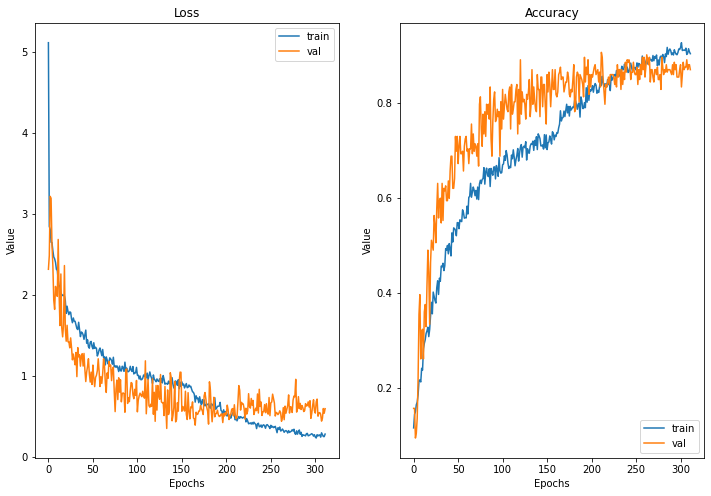

In [36]:
i = 0
for train_idx, valid_idx in sk_fold.split(X_trains, y_trains.argmax(1)):
# for train_idx, valid_idx in k_fold.split(X_trains, y_trains.argmax(1)):
    print("model_{}".format(i))
    print("-------------------------------------------------------------------------------------------------------------------------")
#     X_train, y_train, X_t_letter = X_trains[train_idx], y_trains[train_idx], X_train_letter[train_idx]
#     X_valid, y_valid, X_v_letter = X_trains[valid_idx], y_trains[valid_idx], X_train_letter[valid_idx]
    X_train, y_train = X_trains[train_idx], y_trains[train_idx]
    X_valid, y_valid = X_trains[valid_idx], y_trains[valid_idx]
#     
#     X_train = X_train/255.0
#     X_valid = X_valid/255.0
#     print(X_t_letter.shape)
#     print(X_t_letter.shape)
#     print(X_train.shape)
    # callback
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "model/deskewed_alpha_dropout0.5_callback{}.h5".format(i), save_best_only=True, monitor='val_accuracy', mode='auto')
    
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=30)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 100, restore_best_weights = True)
    
    # model
    model = None
    model = rexnet()
    
    # compile
#     losses = {
#         "digit_output" : "categorical_crossentropy",
#         "alpha_output" : "categorical_crossentropy"
#     } 
    
#     lossWeight = {
#         "digit_output" : 1.0,
#         "alpha_output" : 1.0
#     }
    
    model.compile(loss="categorical_crossentropy", optimizer=Adam(
    lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics=['accuracy'])
    
    # train
    history = model.fit(datagen.flow(X_train, y_train, shuffle=True, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=valid_datagen.flow(X_valid, y_valid),
                        verbose=1,
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_steps=X_valid.shape[0] //batch_size,
                        callbacks=[checkpoint_cb, early_stopping, lr_scheduler]
                                  )
    # graph
    plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
    
    i += 1

In [37]:
# for idx in range(num_model):
#     print("model_{}".format(idx+1))
#     print("-------------------------------------------------------------------------------------------------------------------------")
#     X_train, X_valid, y_train, y_valid = train_test_split(X_trains, y_trains, test_size=0.2, stratify=train['digit'])
#     X_train = X_train/255.0
#     X_valid = X_valid/255.0
    
#     model = None
#     model = rexnet()
    
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(
#     lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics=['accuracy'])
    
#     checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#         "model/deskewed_onehot_{}.h5".format(idx), save_best_only=True, monitor='val_accuracy', mode='auto')
    
#     lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.7, patience=30)
    
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 40, restore_best_weights = True)
    
#     history = model.fit(datagen.flow(X_train, y_train, shuffle=True, batch_size=batch_size),
#                                   epochs=epochs, validation_data=(
#                                       X_valid, y_valid),
#                                   verbose=1,
#                                  steps_per_epoch=X_train.shape[0] // batch_size,
#                                   validation_steps=X_valid.shape[0] //batch_size,
#                                   callbacks=[checkpoint_cb, early_stopping, lr_scheduler]
#                                   )
#     plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

## Predict

In [38]:
X_test = X_test/255.0

In [39]:
best_model_list = []
for i in range(10):
    best = tf.keras.models.load_model('model/deskewed_alpha_dropout0.5_callback{}.h5'.format(i))
    best_model_list.append(best)

In [40]:
result_list = []
X_valids = X_valid/255.0
X_trains = X_trains/255.0
for idx, model in enumerate(best_model_list):
    result = model.evaluate(, y_valid)
    print("model_{}_acc : {}".format(idx+1, result))

7/7 [==============================] - 27s 4s/step - loss: 0.2147 - accuracy: 0.9265
model_1_acc : [0.21468126773834229, 0.9264705777168274]
7/7 [==============================] - 0s 9ms/step - loss: 0.0338 - accuracy: 0.9902
model_2_acc : [0.03378106653690338, 0.9901960492134094]
7/7 [==============================] - 0s 12ms/step - loss: 0.2583 - accuracy: 0.9363
model_3_acc : [0.25834980607032776, 0.936274528503418]
7/7 [==============================] - 0s 11ms/step - loss: 0.0540 - accuracy: 0.9804
model_4_acc : [0.05401965230703354, 0.9803921580314636]
7/7 [==============================] - 0s 8ms/step - loss: 0.1164 - accuracy: 0.9510
model_5_acc : [0.11639489233493805, 0.9509803652763367]
7/7 [==============================] - 0s 10ms/step - loss: 0.0977 - accuracy: 0.9755
model_6_acc : [0.09774738550186157, 0.9754902124404907]
7/7 [==============================] - 0s 10ms/step - loss: 0.2615 - accuracy: 0.9069
model_7_acc : [0.2614598274230957, 0.906862735748291]
7/7 [=======

In [48]:
# result_list = []
# # X_valids = X_valid/255.0
# A = X_trains/255.0
# for idx, model in enumerate(best_model_list):
#     result = model.evaluate(A, y_trains)
#     print("model_{}_acc : {}".format(idx+1, result))

64/64 [==============================] - 1s 13ms/step - loss: 0.2328 - accuracy: 0.9229
model_1_acc : [0.2327805757522583, 0.9228515625]
64/64 [==============================] - 1s 10ms/step - loss: 0.1632 - accuracy: 0.9570
model_2_acc : [0.16320563852787018, 0.95703125]
64/64 [==============================] - 1s 12ms/step - loss: 0.2339 - accuracy: 0.9292
model_3_acc : [0.23386874794960022, 0.92919921875]
64/64 [==============================] - 1s 10ms/step - loss: 0.1027 - accuracy: 0.9673
model_4_acc : [0.10273147374391556, 0.96728515625]
64/64 [==============================] - 1s 12ms/step - loss: 0.1928 - accuracy: 0.9419
model_5_acc : [0.1927834153175354, 0.94189453125]
64/64 [==============================] - 1s 11ms/step - loss: 0.0829 - accuracy: 0.9771
model_6_acc : [0.08287159353494644, 0.97705078125]
64/64 [==============================] - 1s 12ms/step - loss: 0.3273 - accuracy: 0.9033
model_7_acc : [0.3272743821144104, 0.9033203125]
64/64 [============================

In [41]:
pred_list = []
for idx, model in enumerate(best_model_list):
    pred = model.predict(X_test)
    pred_list.append(pred)

In [42]:
final_pred = np.array([0]*204800).reshape(20480, 10).astype('float64')
for pred in pred_list:
    final_pred += pred
final_pred = np.argmax(final_pred, axis=1)

In [43]:
# test = np.array([0]*204800).reshape(20480, 10).astype('float64')
# for pred in pred_list:
#     test += pred
#     print(test[0])
#     print("a")
# print(test[0])
# # final_pred = np.argmax(final_pred, axis=1)

In [44]:
final_pred

array([6, 9, 8, ..., 6, 3, 0])

In [45]:
submission['digit'] = final_pred

In [46]:
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3


In [47]:
submission.to_csv('./submission/deskewed_alpha_dropout0.5_callback_submission.csv', index=False)